In [1]:
import os
import warnings
import sys
import pandas as pd
sys.path.append("../")
from dotenv import load_dotenv
from big_query import UniswapV3Data
load_dotenv()
warnings.filterwarnings('ignore')

In [2]:
univ3_data = UniswapV3Data(path='../data/', project_id=os.getenv("PROJECT_ID"), key_path=os.getenv("KEY_PATH"))
ETH_USDC_ADDRESS = "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"
swap_data = univ3_data.get_swap_data(address=ETH_USDC_ADDRESS, download_latest=False)
swap_data.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,sender,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick
0,2021-05-05 01:56:23+00:00,12371376,0xce7c3c307d820785caa12938012372fc9366a614a6aa...,26,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xe592427a0aece92de3edee1f18e0157c05861564,0x5eefc9306f11a824762ccdaedac41049efc7fcc8,-329608,100000000000000,1377932816571815120446551350158799,4303369674465501,195285
1,2021-05-05 08:23:26+00:00,12373132,0x9a1c51b0bffbf840948f3b6e3f3e495ba1cd3fa64854...,192,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xe592427a0aece92de3edee1f18e0157c05861564,0xe592427a0aece92de3edee1f18e0157c05861564,-164694492,50000000000000000,1378850591292581266780357299649652,4303369674465501,195298
2,2021-05-05 09:50:51+00:00,12373520,0xc58715c62a5bf70a6ca09f0e51546d6cad76c8d4fff0...,8,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xe592427a0aece92de3edee1f18e0157c05861564,0xfb36693ac2dbe8dfc9f89dd0de6015c6ea66b0bf,-329169,100000000000000,1378852426842022799073024911548633,4303369674465501,195298
3,2021-05-05 11:59:57+00:00,12374077,0x288c21b8b4fbf449b1d086a06e43b124ac2bc088c3f5...,86,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xe592427a0aece92de3edee1f18e0157c05861564,0xfb36693ac2dbe8dfc9f89dd0de6015c6ea66b0bf,2,-329169,1378852426842016741051966412054516,4304946248093346,195298
4,2021-05-05 12:56:56+00:00,12374320,0x67502d8ba373287f6d301f6baa77c5a5f4c80d0753c3...,257,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xe592427a0aece92de3edee1f18e0157c05861564,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,1559137299,-467880854065813753,1370241555019945317645788135487819,4304946248093346,195173


In [3]:
# start_block, end_block = swap_data.block_number.iloc[0], swap_data.block_number.iloc[-1] 
# gas_price = univ3_data.get_gas_data(start_block, end_block)
# gas_price.head()

```Based on historic vol you can actually know what price what's the propability that our option expires ITM or OTM```

In [4]:
swap_data.block_timestamp =  pd.to_datetime(swap_data['block_timestamp'], origin='unix')
swap_data.set_index('block_timestamp', inplace=True)
DATE_BEGIN                 = pd.to_datetime('2021-07-15 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2021-08-19 00:00PM',utc=True)
swap_data = swap_data[DATE_BEGIN:DATE_END]
DECIMALS_0 = 6
DECIMALS_1 = 18
swap_data['amount0']  = swap_data.amount0.astype('float')/(10**DECIMALS_0)
swap_data['amount1']  = swap_data.amount1.astype('float')/(10**DECIMALS_1)
swap_data['liquidity']  = swap_data.liquidity.astype('float')
swap_data['traded_in'] = swap_data.apply(lambda x: -x['amount0'] if (x['amount0'] < 0) else -x['amount1'],axis=1)
swap_data['traded_out'] = swap_data.apply(lambda x:  x['amount0'] if (x['amount0'] > 0) else  x['amount1'],axis=1)
swap_data['token_in']        = swap_data.apply(lambda x: 'token0' if (x['amount0'] < 0) else 'token1',axis=1)


price_data = pd.Series((1.0001**swap_data.tick.values)/10**(DECIMALS_1-DECIMALS_0),index=swap_data.index)

In [5]:
%%time
from rolling_strategy import RollingStrategy
import strategy_state 

Strategy = RollingStrategy(duration_param='1 day', percentage_param=0.3, buffer_param='6 Hour')
# Initial Position Details
INITIAL_TOKEN_0            = 100000
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*price_data[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0
FEE_TIER                   = 0.003

output = strategy_state.simulate_strategy(price_data,swap_data,Strategy,INITIAL_TOKEN_0,INITIAL_TOKEN_1,fee_tier=FEE_TIER,decimals_0=DECIMALS_0,decimals_1=DECIMALS_1)

Initializing strategy...
CPU times: user 1min 51s, sys: 483 ms, total: 1min 51s
Wall time: 1min 51s


In [6]:
sim_data = strategy_state.generate_simulation_series(output,Strategy)
strat_result = strategy_state.analyze_strategy(sim_data,INITIAL_POSITION_VALUE)
print(strat_result)

{'days_strategy': 34, 'gross_fee_apr': 1.030155711049514, 'gross_fee_return': 0.09595971007036569, 'net_apr': 1.9849265610278144, 'net_return': 0.18489726869848133, 'rebalances': 69, 'max_drawdown': 0.18965565987251798, 'volatility': 0.21438618226509643, 'sharpe_ratio': 9.258649694938732, 'impermanent_loss': -0.07406882653110831, 'mean_first_position': 0.15861516642160073, 'median_first_position': 0.07564533240988247, 'final_value': 236979.45373969627}


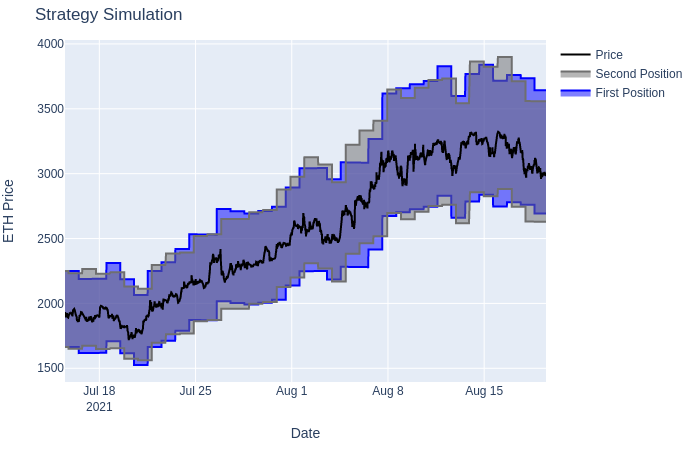

In [7]:
strategy_state.plot_strategy(sim_data,'ETH Price','#0000FF')

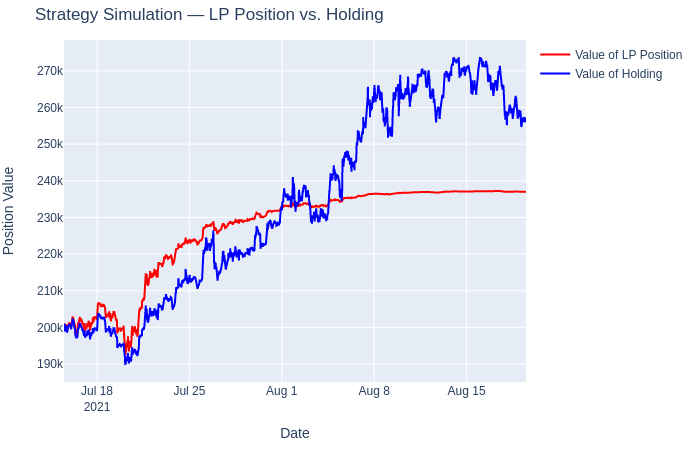

In [8]:
strategy_state.plot_position_value(sim_data)

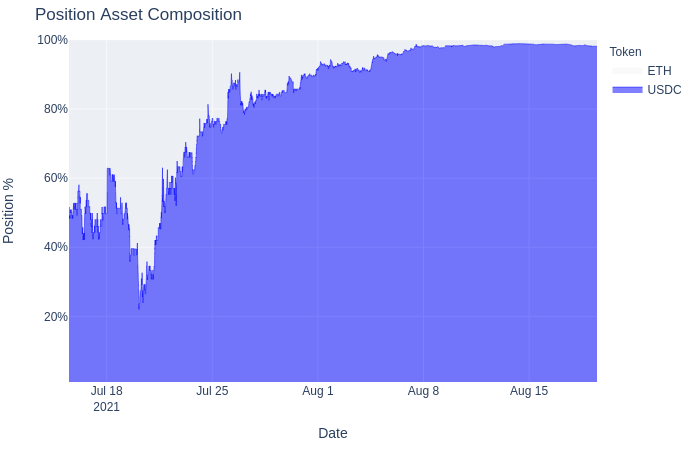

In [9]:
strategy_state.plot_asset_composition(sim_data, 'USDC', 'ETH')

In [10]:
sim_data.columns

Index(['time', 'price', 'reset_point', 'reset_reason', 'first_position_lower',
       'first_position_upper', 'second_position_lower',
       'second_position_upper', 'token_0_fees', 'token_1_fees',
       'token_0_fees_uncollected', 'token_1_fees_uncollected',
       'token_0_left_over', 'token_1_left_over', 'token_0_allocated',
       'token_1_allocated', 'token_0_total', 'token_1_total', 'value_position',
       'value_allocated', 'value_left_over', 'first_position_value',
       'second_position_value', 'value_position_usd', 'cum_fees_usd',
       'token_0_hold_usd', 'token_1_hold_usd', 'value_hold_usd'],
      dtype='object')

In [11]:
out = sim_data.copy()
out['reset_point'] +=(out['reset_point'].shift(-1))
out[out['reset_point']==True].drop(columns=['time','first_position_lower',
       'first_position_upper', 'second_position_lower',
       'second_position_upper', 'token_0_hold_usd', 'token_1_hold_usd', 'value_hold_usd'])

,price,reset_point,reset_reason,token_0_fees,token_1_fees,token_0_fees_uncollected,token_1_fees_uncollected,token_0_left_over,token_1_left_over,token_0_allocated,token_1_allocated,token_0_total,token_1_total,value_position,value_allocated,value_left_over,first_position_value,second_position_value,value_position_usd,cum_fees_usd
time,,,,,,,,,,,,,,,,,,,,
2021-07-15 17:59:25+00:00,0.000528,1,,0.000000,0.001148,168.282937,0.079096,5.717144e+04,2.613704e+01,38985.916574,28.158641,96325.642930,54.374776,199371.117881,92349.271884,106703.668792,92349.271884,0.000000,199371.117881,319.327252
2021-07-15 18:03:15+00:00,0.000527,1,second_position_initialization,0.000000,0.002026,168.282937,0.081121,1.459908e+04,3.552714e-15,83476.722131,53.283364,98244.081100,53.364485,199547.016730,184625.663184,14599.076032,92436.798243,92188.864941,199547.016730,323.172537
2021-07-16 11:59:26+00:00,0.000538,1,,0.580234,0.000000,698.543654,0.286087,1.459908e+04,3.552714e-15,68220.918559,61.406282,83518.538245,61.692369,198196.885924,182367.466920,14599.076032,91287.676191,91079.790729,198196.885924,1245.702246
2021-07-16 12:07:54+00:00,0.000538,1,first_position_rebalance,0.579841,0.000256,0.000000,0.000000,-7.275958e-12,9.609555e-01,83519.118086,60.731669,83519.118086,61.692625,198232.347992,196445.516676,1786.831315,105348.887098,91096.629578,198232.347992,1246.757369
2021-07-16 17:52:02+00:00,0.000520,1,,0.191725,0.000000,128.885285,0.169696,-7.275958e-12,9.609555e-01,108207.656674,47.664944,108336.541959,48.795596,202253.343357,199948.295000,1849.549529,107095.068065,92853.226934,202253.343357,1697.594829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-18 00:05:02+00:00,0.000331,1,second_position_rebalance,0.073433,0.000018,0.000000,0.000000,2.305276e+05,2.220446e-16,2446.318687,1.319908,232973.959971,1.319908,236967.621408,6439.980124,230527.641284,3058.508267,3381.471857,236967.621408,19120.686379
2021-08-18 15:48:03+00:00,0.000324,1,,0.000000,0.000050,14.628684,0.005845,2.305276e+05,2.220446e-16,2974.861978,1.146806,233517.131946,1.152651,237079.801948,6519.465781,230527.641284,3101.507197,3417.958584,237079.801948,19153.041260
2021-08-18 15:54:49+00:00,0.000323,1,first_position_rebalance,0.000000,0.000050,0.000000,0.000000,2.300406e+05,8.881784e-16,3476.560061,1.152701,233517.131946,1.152701,237087.087577,7046.515692,230040.571884,3625.329234,3421.186459,237087.087577,19153.194776


In [12]:
out.token_1_left_over.value_counts()

 0.000000e+00    5754
 8.881784e-16    3542
 1.110223e-16    1336
-1.776357e-15    1199
 4.440892e-16    1137
 1.776357e-15    1002
 9.992007e-16     913
 5.551115e-16     900
 2.220446e-16     850
 1.332268e-15     779
 3.552714e-15     767
 1.110223e-15     659
 6.661338e-16     645
 7.357346e-01     528
 1.094136e+01     463
 3.516230e+01     441
 3.330669e-16     439
-3.552714e-15     424
 7.771561e-16     399
 8.326673e-16     394
 1.577413e+01     350
 2.613704e+01     237
 9.609555e-01     194
 3.236886e+01     187
-8.881784e-16     166
 3.885781e-16     140
 1.665335e-16     111
Name: token_1_left_over, dtype: int64